In [18]:
import os
import numpy as np
from sklearn.metrics import f1_score
from skimage.io import imread
from skimage.transform import resize,rotate
from skimage.measure import find_contours
from skimage.util import invert
from skimage.color import rgb2gray
import matplotlib.pyplot as plt
plt.style.use('default')
from keras.optimizers import SGD, Adam
import keras.backend as K
import keras
from keras import layers, activations
from keras.models import Model
from keras.preprocessing.image import load_img,img_to_array
from keras.utils.vis_utils import plot_model
from keras.engine.topology import Layer
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import model_from_json
from IPython.display import Image
import tensorflow as tf
import Augmentor
import yaml
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator


In [19]:
train_x = []
train_y = []
test_x = []
test_y = []
####path
images_names_train=os.listdir('dataset-5.0/train/image/')
mask_names_train=os.listdir('dataset-5.0/train/annotation/')
############################################################
images_names_test=os.listdir('dataset-4.0/test/image/')
mask_names_test=os.listdir('dataset-4.0/test/annotation/')

In [20]:
####dataset construct
for i in images_names_train:
    x_path = os.path.join('dataset-5.0/train/image/'+ i) 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    train_x.append(img)
for j in mask_names_train:
    y_path = os.path.join('dataset-5.0/train/annotation/'+ j) 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    y[:,:, 0] = weed
    y[:, :, 1] = crop
    
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    
    train_y.append(y)
############################################################
for i in images_names_test:
    x_path = os.path.join('dataset-4.0/test/image/'+ i) 
    img = load_img(x_path,target_size=(128,128))
    img = img_to_array(img)/255
    test_x.append(img)
for j in mask_names_test:
    y_path = os.path.join('dataset-4.0/test/annotation/'+ j) 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    
    weed = img[:,:,0]
    crop = img[:,:,1]

    y = np.zeros((128,128,3))
    y[:,:, 0] = weed
    y[:, :, 1] = crop
    
    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1)*1
    y[:,:, 2] = back
    
    y = np.reshape(y,(128*128,3))
    
    test_y.append(y)

train_x = np.array(train_x)
train_y = np.array(train_y)
test_x = np.array(test_x)
test_y = np.array(test_y)



print(train_x.shape)
print(train_y.shape)
print(test_x.shape)
print(test_y.shape)

(144, 128, 128, 3)
(144, 16384, 3)
(26, 128, 128, 3)
(26, 16384, 3)


61475.0
133154.0
2164667


Text(0, 0.5, 'pixel')

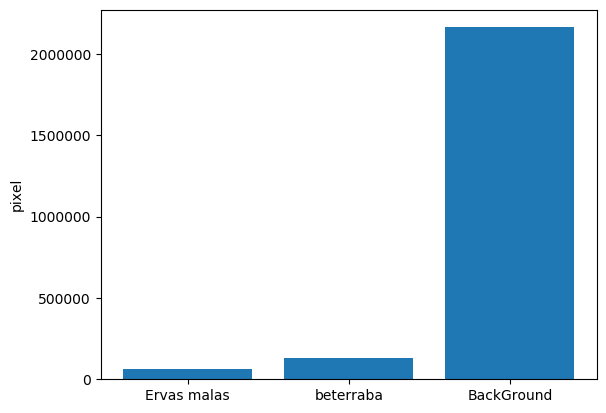

In [22]:
#analise pixel lvl for classess
weed_pixel = 0
crop_pixel = 0
background_pixel = 0
for j in mask_names_train:
    y_path = os.path.join('dataset-5.0/train/annotation/'+ j) 
    img = load_img(y_path,target_size=(128,128))
    img = img_to_array(img)/255
    weed = img[:,:,0]
    _pixel = np.sum(weed.flatten())
    weed_pixel += _pixel 
    crop = img[:,:,1]
    _pixel = np.sum(crop.flatten())
    crop_pixel += _pixel

    back = img.copy()
    back = np.all(img == [0, 0, 0],axis=-1) * 1
    _pixel = np.sum(back.flatten())
    background_pixel += _pixel


print(weed_pixel)
print(crop_pixel)
print(background_pixel)

plt.bar(["Ervas malas","beterraba","BackGround"],[weed_pixel,crop_pixel,background_pixel])
plt.ylabel("pixel")

In [23]:
categorical_weight = [background_pixel/weed_pixel, background_pixel/crop_pixel, 1]
print(categorical_weight)

[35.21215128100854, 16.256867987443112, 1]


In [24]:
def weights_categorical_crossentropy(weights):
   
    if isinstance(weights,list) or isinstance(np.ndarray):
        weights=K.variable(weights)

    def loss(target,output,from_logits=False):
        if not from_logits:
            output /= tf.reduce_sum(output,
                                    len(output.get_shape()) - 1,
                                    True)
            _epsilon = tf.convert_to_tensor(K.epsilon(), dtype=output.dtype.base_dtype)
            output = tf.clip_by_value(output, _epsilon, 1. - _epsilon)
            weighted_losses = target * tf.log(output) * weights
            return - tf.reduce_sum(weighted_losses,len(output.get_shape()) - 1)
        else:
            raise ValueError('error')
    return loss


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.is_nan(f1), tf.zeros_like(f1), f1)
    return K.mean(f1)
def precision(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    return K.mean(p)

def recall(y_true, y_pred):
    y_pred = K.round(y_pred)
    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    # tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    return K.mean(r)
    
    
    

In [25]:
def model1(labels=1,h=128,w=128, out_activation = "sigmoid"):
    
    class MySoftmax(Layer):
        #http://cookie-box.hatenablog.com/entry/2017/08/15/231503 
        def __init__(self, **kwargs):
            super(MySoftmax, self).__init__(**kwargs)
        def call(self, x):
            return(activations.softmax(x, axis=3))

    
    
    #block1, 128x128
    inputs = layers.Input(shape=(h,w,3))
    conv11 = layers.Conv2D(8,(3,3),activation="relu",padding="same")(inputs)
    conv12= layers.Conv2D(8,(3,3),activation="relu",padding="same")(conv11)
    conv13= layers.Conv2D(8,(3,3),activation="relu",padding="same")(conv12)
    pool1 = layers.MaxPool2D((2,2))(conv13)
    drop1 = layers.Dropout(0.5)(pool1)
   #block2 64x64
    conv21 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(drop1)
    conv22 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv21)
    conv23 = layers.Conv2D(16,(3,3),activation="relu",padding="same")(conv22)
    pool2 = layers.MaxPool2D((2,2))(conv23)
    drop2 = layers.Dropout(0.5)(pool2)
    #block3 32x32
    conv31 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(drop2)
    conv32 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv31)
    conv33 = layers.Conv2D(32,(3,3),activation="relu",padding="same")(conv32)
    pool3 = layers.MaxPool2D((2,2))(conv33)
    drop3 = layers.Dropout(0.3)(pool3)

    #block4 16x16
    conv41 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(drop3)
    conv42 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv41)
    conv43 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv42)
    pool4 = layers.MaxPool2D((2,2))(conv43)
    drop4 = layers.Dropout(0.3)(pool4)
    
    #bottom of Unet 8x8
    conv5 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(drop4)
    conv5 = layers.Conv2D(64,(3,3),activation="relu",padding="same")(conv5)

    #upblock4
    x = layers.UpSampling2D((2,2))(conv5)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv43,x])
    x= layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Conv2D(128,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.2)(x)
    #upblock3
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv33,x])
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(64,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.2)(x)
    #upblock2
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv23,x])
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(32,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #upblock1
    x = layers.UpSampling2D((2,2))(x)
    x = layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.concatenate([conv13,x])
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x= layers.Conv2D(16,(3,3),activation="relu",padding="same")(x)
    x = layers.Dropout(0.5)(x)
    #to label image (2 labels)
    x = layers.Conv2D(labels,(1,1))(x)
    outputs = layers.Activation("relu")(x)
    model = Model(inputs=inputs,outputs=outputs)
    return model



In [26]:
K.clear_session()

custom_loss = weights_categorical_crossentropy(categorical_weight)

 
model=model1(labels=3,out_activation="relu")
l = layers.Reshape((128*128,3))(model.output)
outs = layers.Activation("softmax")(l)

model = Model(inputs=model.input,outputs=outs)
lr = 1e-3
adam = Adam(lr = lr)
model.compile(loss=custom_loss,optimizer=adam,metrics=['accuracy',f1,precision,recall,mean_iou])

In [27]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  224         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 128, 128, 8)  584         conv2d_2[0][0]                   
__________________________________________________________________________________________________
max_poolin

conv2d_22 (Conv2D)              (None, 64, 64, 32)   13856       concatenate_3[0][0]              
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 64, 64, 32)   9248        conv2d_22[0][0]                  
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 64, 64, 32)   0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
up_sampling2d_4 (UpSampling2D)  (None, 128, 128, 32) 0           dropout_7[0][0]                  
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 128, 128, 16) 4624        up_sampling2d_4[0][0]            
__________________________________________________________________________________________________
concatenat

In [42]:
print('Start the training')
#file_name = 'best_model.h5'
#checkpointer = ModelCheckpoint(file_name, monitor='val_acc', save_best_only=True)
early_stop = EarlyStopping(monitor = f1, min_delta = 0.0001, 
                               mode = 'max', patience = 100)
history = model.fit(train_x, train_y, batch_size=80, epochs=1000, 
                    verbose=2,validation_split=0.2)
#del model
#model = load_model(file_name)

Start the training
Train on 115 samples, validate on 29 samples
Epoch 1/1000
 - 8s - loss: 3.0770 - acc: 0.7166 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_iou: 0.1014 - val_loss: 2.8111 - val_acc: 0.9134 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_iou: 0.3333
Epoch 2/1000
 - 1s - loss: 3.0753 - acc: 0.7095 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_iou: 0.3333 - val_loss: 2.8098 - val_acc: 0.9093 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_iou: 0.3333
Epoch 3/1000
 - 1s - loss: 3.0740 - acc: 0.6819 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_iou: 0.3333 - val_loss: 2.8087 - val_acc: 0.8990 - val_f1: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_mean_iou: 0.3333
Epoch 4/1000
 - 1s - loss: 3.0728 - acc: 0.6441 - f1: 0.0000e+00 - precision: 0.0000e+00 - recall: 0.0000e+00 - mean_iou: 0.3333 - val_loss: 2.8075

Epoch 34/1000
 - 1s - loss: 2.3393 - acc: 0.7625 - f1: 0.4074 - precision: 0.4588 - recall: 0.4275 - mean_iou: 0.3975 - val_loss: 2.0234 - val_acc: 0.8548 - val_f1: 0.4594 - val_precision: 0.4738 - val_recall: 0.4863 - val_mean_iou: 0.4002
Epoch 35/1000
 - 1s - loss: 2.3061 - acc: 0.8006 - f1: 0.4248 - precision: 0.4754 - recall: 0.4249 - mean_iou: 0.4025 - val_loss: 1.9068 - val_acc: 0.8350 - val_f1: 0.4483 - val_precision: 0.4596 - val_recall: 0.4953 - val_mean_iou: 0.4056
Epoch 36/1000
 - 1s - loss: 2.2693 - acc: 0.7659 - f1: 0.4180 - precision: 0.4694 - recall: 0.4362 - mean_iou: 0.4076 - val_loss: 1.9157 - val_acc: 0.8571 - val_f1: 0.4597 - val_precision: 0.4745 - val_recall: 0.4859 - val_mean_iou: 0.4102
Epoch 37/1000
 - 1s - loss: 2.2670 - acc: 0.7762 - f1: 0.4273 - precision: 0.4997 - recall: 0.4067 - mean_iou: 0.4122 - val_loss: 1.8597 - val_acc: 0.8473 - val_f1: 0.4504 - val_precision: 0.4546 - val_recall: 0.5079 - val_mean_iou: 0.4150
Epoch 38/1000
 - 1s - loss: 2.2064 - acc

Epoch 69/1000
 - 1s - loss: 1.6038 - acc: 0.8137 - f1: 0.5541 - precision: 0.5496 - recall: 0.6742 - mean_iou: 0.5158 - val_loss: 1.3588 - val_acc: 0.9083 - val_f1: 0.5758 - val_precision: 0.5701 - val_recall: 0.6242 - val_mean_iou: 0.5169
Epoch 70/1000
 - 1s - loss: 1.6246 - acc: 0.8541 - f1: 0.5859 - precision: 0.5849 - recall: 0.6679 - mean_iou: 0.5182 - val_loss: 1.2148 - val_acc: 0.8916 - val_f1: 0.5667 - val_precision: 0.5552 - val_recall: 0.6354 - val_mean_iou: 0.5197
Epoch 71/1000
 - 1s - loss: 1.5821 - acc: 0.8275 - f1: 0.5709 - precision: 0.5611 - recall: 0.6873 - mean_iou: 0.5208 - val_loss: 1.2051 - val_acc: 0.8871 - val_f1: 0.5611 - val_precision: 0.5477 - val_recall: 0.6373 - val_mean_iou: 0.5220
Epoch 72/1000
 - 1s - loss: 1.5738 - acc: 0.8341 - f1: 0.5716 - precision: 0.5601 - recall: 0.6860 - mean_iou: 0.5230 - val_loss: 1.2364 - val_acc: 0.8924 - val_f1: 0.5668 - val_precision: 0.5539 - val_recall: 0.6379 - val_mean_iou: 0.5243
Epoch 73/1000
 - 1s - loss: 1.5732 - acc

Epoch 104/1000
 - 1s - loss: 1.3865 - acc: 0.8586 - f1: 0.6109 - precision: 0.5964 - recall: 0.7120 - mean_iou: 0.5827 - val_loss: 0.9479 - val_acc: 0.9186 - val_f1: 0.6054 - val_precision: 0.5907 - val_recall: 0.6667 - val_mean_iou: 0.5836
Epoch 105/1000
 - 1s - loss: 1.3915 - acc: 0.8447 - f1: 0.6097 - precision: 0.5908 - recall: 0.7261 - mean_iou: 0.5843 - val_loss: 0.9658 - val_acc: 0.9206 - val_f1: 0.6067 - val_precision: 0.5934 - val_recall: 0.6646 - val_mean_iou: 0.5850
Epoch 106/1000
 - 1s - loss: 1.3896 - acc: 0.8576 - f1: 0.6185 - precision: 0.6017 - recall: 0.7233 - mean_iou: 0.5856 - val_loss: 1.0143 - val_acc: 0.9265 - val_f1: 0.6110 - val_precision: 0.6006 - val_recall: 0.6611 - val_mean_iou: 0.5863
Epoch 107/1000
 - 1s - loss: 1.3894 - acc: 0.8678 - f1: 0.6280 - precision: 0.6182 - recall: 0.7149 - mean_iou: 0.5870 - val_loss: 1.0177 - val_acc: 0.9199 - val_f1: 0.6000 - val_precision: 0.5860 - val_recall: 0.6606 - val_mean_iou: 0.5878
Epoch 108/1000
 - 1s - loss: 1.3735 

Epoch 138/1000
 - 1s - loss: 1.2931 - acc: 0.8632 - f1: 0.6323 - precision: 0.6126 - recall: 0.7426 - mean_iou: 0.6230 - val_loss: 0.8509 - val_acc: 0.9276 - val_f1: 0.6209 - val_precision: 0.6063 - val_recall: 0.6777 - val_mean_iou: 0.6234
Epoch 139/1000
 - 1s - loss: 1.2907 - acc: 0.8669 - f1: 0.6334 - precision: 0.6133 - recall: 0.7431 - mean_iou: 0.6239 - val_loss: 0.8917 - val_acc: 0.9329 - val_f1: 0.6220 - val_precision: 0.6088 - val_recall: 0.6743 - val_mean_iou: 0.6244
Epoch 140/1000
 - 1s - loss: 1.2906 - acc: 0.8658 - f1: 0.6354 - precision: 0.6150 - recall: 0.7399 - mean_iou: 0.6249 - val_loss: 0.8314 - val_acc: 0.9253 - val_f1: 0.6189 - val_precision: 0.6030 - val_recall: 0.6793 - val_mean_iou: 0.6253
Epoch 141/1000
 - 1s - loss: 1.2830 - acc: 0.8637 - f1: 0.6266 - precision: 0.6063 - recall: 0.7384 - mean_iou: 0.6257 - val_loss: 0.9367 - val_acc: 0.9336 - val_f1: 0.6182 - val_precision: 0.6047 - val_recall: 0.6709 - val_mean_iou: 0.6262
Epoch 142/1000
 - 1s - loss: 1.2942 

Epoch 172/1000
 - 1s - loss: 1.2473 - acc: 0.8500 - f1: 0.6176 - precision: 0.5973 - recall: 0.7422 - mean_iou: 0.6491 - val_loss: 0.8354 - val_acc: 0.9265 - val_f1: 0.6169 - val_precision: 0.5999 - val_recall: 0.6801 - val_mean_iou: 0.6493
Epoch 173/1000
 - 1s - loss: 1.2341 - acc: 0.8753 - f1: 0.6451 - precision: 0.6209 - recall: 0.7516 - mean_iou: 0.6496 - val_loss: 0.8497 - val_acc: 0.9381 - val_f1: 0.6308 - val_precision: 0.6183 - val_recall: 0.6796 - val_mean_iou: 0.6500
Epoch 174/1000
 - 1s - loss: 1.2448 - acc: 0.8825 - f1: 0.6532 - precision: 0.6330 - recall: 0.7555 - mean_iou: 0.6504 - val_loss: 0.8328 - val_acc: 0.9367 - val_f1: 0.6296 - val_precision: 0.6163 - val_recall: 0.6802 - val_mean_iou: 0.6508
Epoch 175/1000
 - 1s - loss: 1.2268 - acc: 0.8686 - f1: 0.6412 - precision: 0.6219 - recall: 0.7490 - mean_iou: 0.6511 - val_loss: 0.8396 - val_acc: 0.9298 - val_f1: 0.6208 - val_precision: 0.6057 - val_recall: 0.6788 - val_mean_iou: 0.6514
Epoch 176/1000
 - 1s - loss: 1.2495 

Epoch 206/1000
 - 1s - loss: 1.1711 - acc: 0.8862 - f1: 0.6637 - precision: 0.6442 - recall: 0.7593 - mean_iou: 0.6685 - val_loss: 0.8534 - val_acc: 0.9374 - val_f1: 0.6295 - val_precision: 0.6156 - val_recall: 0.6812 - val_mean_iou: 0.6688
Epoch 207/1000
 - 1s - loss: 1.1693 - acc: 0.8689 - f1: 0.6419 - precision: 0.6218 - recall: 0.7513 - mean_iou: 0.6691 - val_loss: 0.8813 - val_acc: 0.9346 - val_f1: 0.6228 - val_precision: 0.6087 - val_recall: 0.6771 - val_mean_iou: 0.6693
Epoch 208/1000
 - 1s - loss: 1.1835 - acc: 0.8659 - f1: 0.6434 - precision: 0.6264 - recall: 0.7438 - mean_iou: 0.6695 - val_loss: 0.8640 - val_acc: 0.9370 - val_f1: 0.6277 - val_precision: 0.6146 - val_recall: 0.6787 - val_mean_iou: 0.6697
Epoch 209/1000
 - 1s - loss: 1.1655 - acc: 0.8690 - f1: 0.6407 - precision: 0.6242 - recall: 0.7429 - mean_iou: 0.6700 - val_loss: 0.9019 - val_acc: 0.9418 - val_f1: 0.6330 - val_precision: 0.6218 - val_recall: 0.6788 - val_mean_iou: 0.6702
Epoch 210/1000
 - 1s - loss: 1.1701 

Epoch 240/1000
 - 1s - loss: 1.0998 - acc: 0.8673 - f1: 0.6432 - precision: 0.6228 - recall: 0.7562 - mean_iou: 0.6843 - val_loss: 0.8391 - val_acc: 0.9386 - val_f1: 0.6333 - val_precision: 0.6191 - val_recall: 0.6849 - val_mean_iou: 0.6845
Epoch 241/1000
 - 1s - loss: 1.1107 - acc: 0.8663 - f1: 0.6417 - precision: 0.6165 - recall: 0.7628 - mean_iou: 0.6847 - val_loss: 0.9312 - val_acc: 0.9443 - val_f1: 0.6357 - val_precision: 0.6246 - val_recall: 0.6799 - val_mean_iou: 0.6849
Epoch 242/1000
 - 1s - loss: 1.0938 - acc: 0.8666 - f1: 0.6410 - precision: 0.6191 - recall: 0.7533 - mean_iou: 0.6851 - val_loss: 1.0304 - val_acc: 0.9489 - val_f1: 0.6359 - val_precision: 0.6281 - val_recall: 0.6735 - val_mean_iou: 0.6854
Epoch 243/1000
 - 1s - loss: 1.1003 - acc: 0.8681 - f1: 0.6464 - precision: 0.6256 - recall: 0.7554 - mean_iou: 0.6856 - val_loss: 0.8744 - val_acc: 0.9397 - val_f1: 0.6335 - val_precision: 0.6191 - val_recall: 0.6847 - val_mean_iou: 0.6858
Epoch 244/1000
 - 1s - loss: 1.0950 

Epoch 274/1000
 - 1s - loss: 1.1305 - acc: 0.8525 - f1: 0.6270 - precision: 0.6017 - recall: 0.7579 - mean_iou: 0.6967 - val_loss: 0.7879 - val_acc: 0.9357 - val_f1: 0.6323 - val_precision: 0.6164 - val_recall: 0.6879 - val_mean_iou: 0.6968
Epoch 275/1000
 - 1s - loss: 1.1131 - acc: 0.8699 - f1: 0.6414 - precision: 0.6156 - recall: 0.7562 - mean_iou: 0.6970 - val_loss: 0.7927 - val_acc: 0.9412 - val_f1: 0.6382 - val_precision: 0.6253 - val_recall: 0.6861 - val_mean_iou: 0.6972
Epoch 276/1000
 - 1s - loss: 1.0904 - acc: 0.8741 - f1: 0.6509 - precision: 0.6278 - recall: 0.7620 - mean_iou: 0.6974 - val_loss: 0.7790 - val_acc: 0.9398 - val_f1: 0.6367 - val_precision: 0.6236 - val_recall: 0.6859 - val_mean_iou: 0.6976
Epoch 277/1000
 - 1s - loss: 1.0971 - acc: 0.8736 - f1: 0.6487 - precision: 0.6270 - recall: 0.7586 - mean_iou: 0.6977 - val_loss: 0.7610 - val_acc: 0.9340 - val_f1: 0.6307 - val_precision: 0.6151 - val_recall: 0.6870 - val_mean_iou: 0.6979
Epoch 278/1000
 - 1s - loss: 1.0745 

Epoch 308/1000
 - 1s - loss: 0.9798 - acc: 0.8782 - f1: 0.6540 - precision: 0.6271 - recall: 0.7679 - mean_iou: 0.7084 - val_loss: 0.9071 - val_acc: 0.9418 - val_f1: 0.6365 - val_precision: 0.6249 - val_recall: 0.6825 - val_mean_iou: 0.7086
Epoch 309/1000
 - 1s - loss: 0.9653 - acc: 0.8665 - f1: 0.6436 - precision: 0.6163 - recall: 0.7711 - mean_iou: 0.7088 - val_loss: 0.8886 - val_acc: 0.9346 - val_f1: 0.6295 - val_precision: 0.6166 - val_recall: 0.6811 - val_mean_iou: 0.7089
Epoch 310/1000
 - 1s - loss: 0.9641 - acc: 0.8548 - f1: 0.6374 - precision: 0.6090 - recall: 0.7722 - mean_iou: 0.7091 - val_loss: 0.9008 - val_acc: 0.9383 - val_f1: 0.6337 - val_precision: 0.6210 - val_recall: 0.6832 - val_mean_iou: 0.7092
Epoch 311/1000
 - 1s - loss: 0.9483 - acc: 0.8598 - f1: 0.6384 - precision: 0.6108 - recall: 0.7701 - mean_iou: 0.7094 - val_loss: 0.9860 - val_acc: 0.9476 - val_f1: 0.6402 - val_precision: 0.6303 - val_recall: 0.6813 - val_mean_iou: 0.7096
Epoch 312/1000
 - 1s - loss: 0.9483 

Epoch 342/1000
 - 1s - loss: 0.8787 - acc: 0.8607 - f1: 0.6421 - precision: 0.6109 - recall: 0.7855 - mean_iou: 0.7198 - val_loss: 1.1249 - val_acc: 0.9466 - val_f1: 0.6326 - val_precision: 0.6235 - val_recall: 0.6732 - val_mean_iou: 0.7200
Epoch 343/1000
 - 1s - loss: 0.8891 - acc: 0.8808 - f1: 0.6585 - precision: 0.6278 - recall: 0.7824 - mean_iou: 0.7201 - val_loss: 0.8245 - val_acc: 0.9359 - val_f1: 0.6348 - val_precision: 0.6182 - val_recall: 0.6912 - val_mean_iou: 0.7203
Epoch 344/1000
 - 1s - loss: 0.8936 - acc: 0.8522 - f1: 0.6314 - precision: 0.6020 - recall: 0.7852 - mean_iou: 0.7205 - val_loss: 0.9151 - val_acc: 0.9384 - val_f1: 0.6309 - val_precision: 0.6148 - val_recall: 0.6863 - val_mean_iou: 0.7206
Epoch 345/1000
 - 1s - loss: 0.8890 - acc: 0.8745 - f1: 0.6522 - precision: 0.6169 - recall: 0.7889 - mean_iou: 0.7207 - val_loss: 0.8602 - val_acc: 0.9376 - val_f1: 0.6334 - val_precision: 0.6181 - val_recall: 0.6870 - val_mean_iou: 0.7209
Epoch 346/1000
 - 1s - loss: 0.9070 

Epoch 376/1000
 - 1s - loss: 0.8068 - acc: 0.8704 - f1: 0.6511 - precision: 0.6131 - recall: 0.8033 - mean_iou: 0.7300 - val_loss: 1.0470 - val_acc: 0.9489 - val_f1: 0.6424 - val_precision: 0.6313 - val_recall: 0.6849 - val_mean_iou: 0.7301
Epoch 377/1000
 - 1s - loss: 0.8052 - acc: 0.8720 - f1: 0.6491 - precision: 0.6152 - recall: 0.7920 - mean_iou: 0.7303 - val_loss: 1.0223 - val_acc: 0.9479 - val_f1: 0.6415 - val_precision: 0.6302 - val_recall: 0.6845 - val_mean_iou: 0.7304
Epoch 378/1000
 - 1s - loss: 0.7986 - acc: 0.8726 - f1: 0.6539 - precision: 0.6186 - recall: 0.7957 - mean_iou: 0.7306 - val_loss: 0.9943 - val_acc: 0.9434 - val_f1: 0.6366 - val_precision: 0.6232 - val_recall: 0.6849 - val_mean_iou: 0.7307
Epoch 379/1000
 - 1s - loss: 0.8076 - acc: 0.8736 - f1: 0.6537 - precision: 0.6164 - recall: 0.7983 - mean_iou: 0.7308 - val_loss: 0.9651 - val_acc: 0.9437 - val_f1: 0.6387 - val_precision: 0.6256 - val_recall: 0.6865 - val_mean_iou: 0.7310
Epoch 380/1000
 - 1s - loss: 0.7932 

Epoch 410/1000
 - 1s - loss: 0.7532 - acc: 0.8729 - f1: 0.6538 - precision: 0.6150 - recall: 0.8065 - mean_iou: 0.7393 - val_loss: 1.0312 - val_acc: 0.9432 - val_f1: 0.6346 - val_precision: 0.6203 - val_recall: 0.6856 - val_mean_iou: 0.7394
Epoch 411/1000
 - 1s - loss: 0.7537 - acc: 0.8705 - f1: 0.6518 - precision: 0.6117 - recall: 0.8052 - mean_iou: 0.7395 - val_loss: 1.1324 - val_acc: 0.9493 - val_f1: 0.6392 - val_precision: 0.6284 - val_recall: 0.6820 - val_mean_iou: 0.7396
Epoch 412/1000
 - 1s - loss: 0.7531 - acc: 0.8780 - f1: 0.6569 - precision: 0.6191 - recall: 0.7984 - mean_iou: 0.7398 - val_loss: 1.1272 - val_acc: 0.9467 - val_f1: 0.6358 - val_precision: 0.6240 - val_recall: 0.6808 - val_mean_iou: 0.7399
Epoch 413/1000
 - 1s - loss: 0.7454 - acc: 0.8729 - f1: 0.6554 - precision: 0.6156 - recall: 0.8074 - mean_iou: 0.7400 - val_loss: 0.9811 - val_acc: 0.9430 - val_f1: 0.6379 - val_precision: 0.6241 - val_recall: 0.6871 - val_mean_iou: 0.7402
Epoch 414/1000
 - 1s - loss: 0.7465 

Epoch 444/1000
 - 1s - loss: 0.7125 - acc: 0.8707 - f1: 0.6496 - precision: 0.6094 - recall: 0.8084 - mean_iou: 0.7476 - val_loss: 1.0136 - val_acc: 0.9431 - val_f1: 0.6387 - val_precision: 0.6242 - val_recall: 0.6888 - val_mean_iou: 0.7477
Epoch 445/1000
 - 1s - loss: 0.6959 - acc: 0.8739 - f1: 0.6554 - precision: 0.6139 - recall: 0.8182 - mean_iou: 0.7478 - val_loss: 1.1099 - val_acc: 0.9489 - val_f1: 0.6423 - val_precision: 0.6311 - val_recall: 0.6845 - val_mean_iou: 0.7480
Epoch 446/1000
 - 1s - loss: 0.7012 - acc: 0.8798 - f1: 0.6637 - precision: 0.6243 - recall: 0.8083 - mean_iou: 0.7481 - val_loss: 1.1249 - val_acc: 0.9496 - val_f1: 0.6421 - val_precision: 0.6311 - val_recall: 0.6841 - val_mean_iou: 0.7482
Epoch 447/1000
 - 1s - loss: 0.6844 - acc: 0.8796 - f1: 0.6607 - precision: 0.6210 - recall: 0.8112 - mean_iou: 0.7483 - val_loss: 1.2570 - val_acc: 0.9489 - val_f1: 0.6356 - val_precision: 0.6242 - val_recall: 0.6793 - val_mean_iou: 0.7484
Epoch 448/1000
 - 1s - loss: 0.7014 

Epoch 478/1000
 - 1s - loss: 0.6498 - acc: 0.8833 - f1: 0.6672 - precision: 0.6237 - recall: 0.8240 - mean_iou: 0.7553 - val_loss: 1.2448 - val_acc: 0.9497 - val_f1: 0.6386 - val_precision: 0.6270 - val_recall: 0.6817 - val_mean_iou: 0.7554
Epoch 479/1000
 - 1s - loss: 0.6514 - acc: 0.8834 - f1: 0.6665 - precision: 0.6225 - recall: 0.8172 - mean_iou: 0.7555 - val_loss: 1.0235 - val_acc: 0.9436 - val_f1: 0.6405 - val_precision: 0.6262 - val_recall: 0.6900 - val_mean_iou: 0.7556
Epoch 480/1000
 - 1s - loss: 0.6610 - acc: 0.8716 - f1: 0.6553 - precision: 0.6137 - recall: 0.8218 - mean_iou: 0.7557 - val_loss: 1.4117 - val_acc: 0.9516 - val_f1: 0.6347 - val_precision: 0.6253 - val_recall: 0.6744 - val_mean_iou: 0.7558
Epoch 481/1000
 - 1s - loss: 0.6580 - acc: 0.8879 - f1: 0.6750 - precision: 0.6311 - recall: 0.8223 - mean_iou: 0.7559 - val_loss: 1.1696 - val_acc: 0.9457 - val_f1: 0.6354 - val_precision: 0.6221 - val_recall: 0.6833 - val_mean_iou: 0.7560
Epoch 482/1000
 - 1s - loss: 0.6468 

Epoch 512/1000
 - 1s - loss: 0.6156 - acc: 0.8827 - f1: 0.6634 - precision: 0.6202 - recall: 0.8220 - mean_iou: 0.7622 - val_loss: 1.3401 - val_acc: 0.9504 - val_f1: 0.6387 - val_precision: 0.6273 - val_recall: 0.6818 - val_mean_iou: 0.7623
Epoch 513/1000
 - 1s - loss: 0.6109 - acc: 0.8854 - f1: 0.6713 - precision: 0.6251 - recall: 0.8307 - mean_iou: 0.7624 - val_loss: 1.2614 - val_acc: 0.9498 - val_f1: 0.6407 - val_precision: 0.6286 - val_recall: 0.6852 - val_mean_iou: 0.7625
Epoch 514/1000
 - 1s - loss: 0.6121 - acc: 0.8829 - f1: 0.6659 - precision: 0.6208 - recall: 0.8244 - mean_iou: 0.7626 - val_loss: 1.3142 - val_acc: 0.9517 - val_f1: 0.6425 - val_precision: 0.6319 - val_recall: 0.6834 - val_mean_iou: 0.7627
Epoch 515/1000
 - 1s - loss: 0.6112 - acc: 0.8857 - f1: 0.6723 - precision: 0.6271 - recall: 0.8317 - mean_iou: 0.7628 - val_loss: 1.3680 - val_acc: 0.9534 - val_f1: 0.6437 - val_precision: 0.6346 - val_recall: 0.6813 - val_mean_iou: 0.7629
Epoch 516/1000
 - 1s - loss: 0.6127 

Epoch 546/1000
 - 1s - loss: 0.5898 - acc: 0.8856 - f1: 0.6699 - precision: 0.6239 - recall: 0.8305 - mean_iou: 0.7685 - val_loss: 1.2848 - val_acc: 0.9521 - val_f1: 0.6453 - val_precision: 0.6345 - val_recall: 0.6861 - val_mean_iou: 0.7686
Epoch 547/1000
 - 1s - loss: 0.5855 - acc: 0.8845 - f1: 0.6707 - precision: 0.6247 - recall: 0.8315 - mean_iou: 0.7686 - val_loss: 1.4104 - val_acc: 0.9560 - val_f1: 0.6473 - val_precision: 0.6391 - val_recall: 0.6826 - val_mean_iou: 0.7687
Epoch 548/1000
 - 1s - loss: 0.5882 - acc: 0.8899 - f1: 0.6732 - precision: 0.6284 - recall: 0.8261 - mean_iou: 0.7688 - val_loss: 1.3212 - val_acc: 0.9514 - val_f1: 0.6413 - val_precision: 0.6300 - val_recall: 0.6832 - val_mean_iou: 0.7689
Epoch 549/1000
 - 1s - loss: 0.5847 - acc: 0.8853 - f1: 0.6641 - precision: 0.6199 - recall: 0.8173 - mean_iou: 0.7690 - val_loss: 1.3461 - val_acc: 0.9496 - val_f1: 0.6371 - val_precision: 0.6249 - val_recall: 0.6815 - val_mean_iou: 0.7691
Epoch 550/1000
 - 1s - loss: 0.5780 

Epoch 580/1000
 - 1s - loss: 0.5549 - acc: 0.8884 - f1: 0.6750 - precision: 0.6279 - recall: 0.8350 - mean_iou: 0.7743 - val_loss: 1.6146 - val_acc: 0.9549 - val_f1: 0.6403 - val_precision: 0.6324 - val_recall: 0.6759 - val_mean_iou: 0.7743
Epoch 581/1000
 - 1s - loss: 0.5602 - acc: 0.8920 - f1: 0.6815 - precision: 0.6357 - recall: 0.8330 - mean_iou: 0.7744 - val_loss: 1.4025 - val_acc: 0.9512 - val_f1: 0.6416 - val_precision: 0.6306 - val_recall: 0.6832 - val_mean_iou: 0.7745
Epoch 582/1000
 - 1s - loss: 0.5620 - acc: 0.8875 - f1: 0.6731 - precision: 0.6270 - recall: 0.8330 - mean_iou: 0.7746 - val_loss: 1.3062 - val_acc: 0.9477 - val_f1: 0.6386 - val_precision: 0.6253 - val_recall: 0.6854 - val_mean_iou: 0.7747
Epoch 583/1000
 - 1s - loss: 0.5555 - acc: 0.8844 - f1: 0.6706 - precision: 0.6228 - recall: 0.8366 - mean_iou: 0.7747 - val_loss: 1.4074 - val_acc: 0.9511 - val_f1: 0.6400 - val_precision: 0.6287 - val_recall: 0.6823 - val_mean_iou: 0.7748
Epoch 584/1000
 - 1s - loss: 0.5594 

Epoch 614/1000
 - 1s - loss: 0.5404 - acc: 0.8934 - f1: 0.6816 - precision: 0.6357 - recall: 0.8347 - mean_iou: 0.7796 - val_loss: 1.5514 - val_acc: 0.9537 - val_f1: 0.6414 - val_precision: 0.6319 - val_recall: 0.6800 - val_mean_iou: 0.7797
Epoch 615/1000
 - 1s - loss: 0.5375 - acc: 0.8902 - f1: 0.6787 - precision: 0.6313 - recall: 0.8384 - mean_iou: 0.7798 - val_loss: 1.6078 - val_acc: 0.9517 - val_f1: 0.6363 - val_precision: 0.6258 - val_recall: 0.6776 - val_mean_iou: 0.7799
Epoch 616/1000
 - 1s - loss: 0.5404 - acc: 0.8914 - f1: 0.6787 - precision: 0.6307 - recall: 0.8395 - mean_iou: 0.7799 - val_loss: 1.4170 - val_acc: 0.9496 - val_f1: 0.6397 - val_precision: 0.6276 - val_recall: 0.6837 - val_mean_iou: 0.7800
Epoch 617/1000
 - 1s - loss: 0.5375 - acc: 0.8860 - f1: 0.6762 - precision: 0.6272 - recall: 0.8444 - mean_iou: 0.7801 - val_loss: 1.6283 - val_acc: 0.9545 - val_f1: 0.6413 - val_precision: 0.6328 - val_recall: 0.6779 - val_mean_iou: 0.7802
Epoch 618/1000
 - 1s - loss: 0.5380 

Epoch 648/1000
 - 1s - loss: 0.5217 - acc: 0.8952 - f1: 0.6857 - precision: 0.6378 - recall: 0.8400 - mean_iou: 0.7846 - val_loss: 1.6507 - val_acc: 0.9522 - val_f1: 0.6374 - val_precision: 0.6274 - val_recall: 0.6778 - val_mean_iou: 0.7846
Epoch 649/1000
 - 1s - loss: 0.5200 - acc: 0.8901 - f1: 0.6771 - precision: 0.6294 - recall: 0.8364 - mean_iou: 0.7847 - val_loss: 1.6634 - val_acc: 0.9539 - val_f1: 0.6399 - val_precision: 0.6308 - val_recall: 0.6782 - val_mean_iou: 0.7848
Epoch 650/1000
 - 1s - loss: 0.5145 - acc: 0.8935 - f1: 0.6817 - precision: 0.6339 - recall: 0.8410 - mean_iou: 0.7848 - val_loss: 1.6932 - val_acc: 0.9528 - val_f1: 0.6371 - val_precision: 0.6274 - val_recall: 0.6769 - val_mean_iou: 0.7849
Epoch 651/1000
 - 1s - loss: 0.5219 - acc: 0.8912 - f1: 0.6804 - precision: 0.6319 - recall: 0.8389 - mean_iou: 0.7850 - val_loss: 1.6134 - val_acc: 0.9507 - val_f1: 0.6367 - val_precision: 0.6261 - val_recall: 0.6788 - val_mean_iou: 0.7851
Epoch 652/1000
 - 1s - loss: 0.5155 

Epoch 682/1000
 - 1s - loss: 0.4872 - acc: 0.9109 - f1: 0.7086 - precision: 0.6601 - recall: 0.8521 - mean_iou: 0.7894 - val_loss: 1.7354 - val_acc: 0.9530 - val_f1: 0.6410 - val_precision: 0.6312 - val_recall: 0.6802 - val_mean_iou: 0.7895
Epoch 683/1000
 - 1s - loss: 0.4906 - acc: 0.9104 - f1: 0.7054 - precision: 0.6567 - recall: 0.8501 - mean_iou: 0.7896 - val_loss: 1.8498 - val_acc: 0.9563 - val_f1: 0.6437 - val_precision: 0.6359 - val_recall: 0.6783 - val_mean_iou: 0.7896
Epoch 684/1000
 - 1s - loss: 0.4852 - acc: 0.9121 - f1: 0.7069 - precision: 0.6592 - recall: 0.8460 - mean_iou: 0.7897 - val_loss: 1.7611 - val_acc: 0.9543 - val_f1: 0.6407 - val_precision: 0.6319 - val_recall: 0.6780 - val_mean_iou: 0.7898
Epoch 685/1000
 - 1s - loss: 0.4868 - acc: 0.9103 - f1: 0.7017 - precision: 0.6543 - recall: 0.8447 - mean_iou: 0.7898 - val_loss: 1.8205 - val_acc: 0.9559 - val_f1: 0.6413 - val_precision: 0.6337 - val_recall: 0.6764 - val_mean_iou: 0.7899
Epoch 686/1000
 - 1s - loss: 0.4808 

Epoch 716/1000
 - 1s - loss: 0.4690 - acc: 0.9143 - f1: 0.7121 - precision: 0.6635 - recall: 0.8540 - mean_iou: 0.7942 - val_loss: 1.8653 - val_acc: 0.9545 - val_f1: 0.6408 - val_precision: 0.6318 - val_recall: 0.6784 - val_mean_iou: 0.7942
Epoch 717/1000
 - 1s - loss: 0.4725 - acc: 0.9125 - f1: 0.7055 - precision: 0.6574 - recall: 0.8470 - mean_iou: 0.7943 - val_loss: 1.8519 - val_acc: 0.9531 - val_f1: 0.6387 - val_precision: 0.6288 - val_recall: 0.6786 - val_mean_iou: 0.7944
Epoch 718/1000
 - 1s - loss: 0.4684 - acc: 0.9125 - f1: 0.7113 - precision: 0.6625 - recall: 0.8530 - mean_iou: 0.7944 - val_loss: 1.8989 - val_acc: 0.9540 - val_f1: 0.6382 - val_precision: 0.6291 - val_recall: 0.6765 - val_mean_iou: 0.7945
Epoch 719/1000
 - 1s - loss: 0.4642 - acc: 0.9147 - f1: 0.7129 - precision: 0.6640 - recall: 0.8569 - mean_iou: 0.7946 - val_loss: 1.8736 - val_acc: 0.9538 - val_f1: 0.6382 - val_precision: 0.6292 - val_recall: 0.6765 - val_mean_iou: 0.7946
Epoch 720/1000
 - 1s - loss: 0.4714 

Epoch 750/1000
 - 2s - loss: 0.4566 - acc: 0.9176 - f1: 0.7155 - precision: 0.6688 - recall: 0.8466 - mean_iou: 0.7986 - val_loss: 1.8947 - val_acc: 0.9547 - val_f1: 0.6414 - val_precision: 0.6325 - val_recall: 0.6788 - val_mean_iou: 0.7987
Epoch 751/1000
 - 2s - loss: 0.4565 - acc: 0.9144 - f1: 0.7137 - precision: 0.6642 - recall: 0.8569 - mean_iou: 0.7987 - val_loss: 1.8798 - val_acc: 0.9553 - val_f1: 0.6427 - val_precision: 0.6339 - val_recall: 0.6797 - val_mean_iou: 0.7988
Epoch 752/1000
 - 2s - loss: 0.4604 - acc: 0.9131 - f1: 0.7091 - precision: 0.6601 - recall: 0.8536 - mean_iou: 0.7989 - val_loss: 2.0053 - val_acc: 0.9564 - val_f1: 0.6419 - val_precision: 0.6342 - val_recall: 0.6769 - val_mean_iou: 0.7989
Epoch 753/1000
 - 2s - loss: 0.4568 - acc: 0.9158 - f1: 0.7123 - precision: 0.6641 - recall: 0.8528 - mean_iou: 0.7990 - val_loss: 1.8035 - val_acc: 0.9521 - val_f1: 0.6395 - val_precision: 0.6289 - val_recall: 0.6804 - val_mean_iou: 0.7991
Epoch 754/1000
 - 2s - loss: 0.4607 

Epoch 784/1000
 - 2s - loss: 0.4488 - acc: 0.9111 - f1: 0.7081 - precision: 0.6588 - recall: 0.8525 - mean_iou: 0.8027 - val_loss: 2.1026 - val_acc: 0.9552 - val_f1: 0.6383 - val_precision: 0.6301 - val_recall: 0.6749 - val_mean_iou: 0.8028
Epoch 785/1000
 - 2s - loss: 0.4481 - acc: 0.9180 - f1: 0.7160 - precision: 0.6681 - recall: 0.8529 - mean_iou: 0.8028 - val_loss: 2.0047 - val_acc: 0.9543 - val_f1: 0.6392 - val_precision: 0.6299 - val_recall: 0.6772 - val_mean_iou: 0.8029
Epoch 786/1000
 - 2s - loss: 0.4486 - acc: 0.9115 - f1: 0.7038 - precision: 0.6545 - recall: 0.8501 - mean_iou: 0.8030 - val_loss: 2.1633 - val_acc: 0.9571 - val_f1: 0.6404 - val_precision: 0.6333 - val_recall: 0.6744 - val_mean_iou: 0.8030
Epoch 787/1000
 - 2s - loss: 0.4469 - acc: 0.9193 - f1: 0.7150 - precision: 0.6678 - recall: 0.8469 - mean_iou: 0.8031 - val_loss: 2.0191 - val_acc: 0.9551 - val_f1: 0.6396 - val_precision: 0.6310 - val_recall: 0.6768 - val_mean_iou: 0.8031
Epoch 788/1000
 - 2s - loss: 0.4474 

Epoch 818/1000
 - 2s - loss: 0.4384 - acc: 0.9127 - f1: 0.7066 - precision: 0.6574 - recall: 0.8509 - mean_iou: 0.8065 - val_loss: 2.2319 - val_acc: 0.9568 - val_f1: 0.6387 - val_precision: 0.6312 - val_recall: 0.6732 - val_mean_iou: 0.8066
Epoch 819/1000
 - 2s - loss: 0.4420 - acc: 0.9186 - f1: 0.7191 - precision: 0.6708 - recall: 0.8560 - mean_iou: 0.8067 - val_loss: 2.0802 - val_acc: 0.9563 - val_f1: 0.6423 - val_precision: 0.6342 - val_recall: 0.6778 - val_mean_iou: 0.8067
Epoch 820/1000
 - 2s - loss: 0.4369 - acc: 0.9143 - f1: 0.7068 - precision: 0.6586 - recall: 0.8466 - mean_iou: 0.8068 - val_loss: 2.2346 - val_acc: 0.9593 - val_f1: 0.6445 - val_precision: 0.6388 - val_recall: 0.6752 - val_mean_iou: 0.8068
Epoch 821/1000
 - 2s - loss: 0.4316 - acc: 0.9213 - f1: 0.7219 - precision: 0.6745 - recall: 0.8535 - mean_iou: 0.8069 - val_loss: 2.0522 - val_acc: 0.9549 - val_f1: 0.6407 - val_precision: 0.6315 - val_recall: 0.6786 - val_mean_iou: 0.8069
Epoch 822/1000
 - 2s - loss: 0.4392 

Epoch 852/1000
 - 2s - loss: 0.5039 - acc: 0.8997 - f1: 0.6861 - precision: 0.6378 - recall: 0.8457 - mean_iou: 0.8101 - val_loss: 1.9242 - val_acc: 0.9568 - val_f1: 0.6442 - val_precision: 0.6382 - val_recall: 0.6765 - val_mean_iou: 0.8101
Epoch 853/1000
 - 2s - loss: 0.4813 - acc: 0.9131 - f1: 0.7163 - precision: 0.6708 - recall: 0.8520 - mean_iou: 0.8102 - val_loss: 1.4668 - val_acc: 0.9477 - val_f1: 0.6410 - val_precision: 0.6272 - val_recall: 0.6887 - val_mean_iou: 0.8102
Epoch 854/1000
 - 2s - loss: 0.4846 - acc: 0.8942 - f1: 0.6819 - precision: 0.6331 - recall: 0.8486 - mean_iou: 0.8102 - val_loss: 2.3424 - val_acc: 0.9596 - val_f1: 0.6400 - val_precision: 0.6354 - val_recall: 0.6691 - val_mean_iou: 0.8103
Epoch 855/1000
 - 2s - loss: 0.4750 - acc: 0.9241 - f1: 0.7273 - precision: 0.6824 - recall: 0.8512 - mean_iou: 0.8103 - val_loss: 1.4521 - val_acc: 0.9502 - val_f1: 0.6454 - val_precision: 0.6327 - val_recall: 0.6902 - val_mean_iou: 0.8104
Epoch 856/1000
 - 2s - loss: 0.4683 

Epoch 886/1000
 - 2s - loss: 0.4235 - acc: 0.9184 - f1: 0.7141 - precision: 0.6663 - recall: 0.8487 - mean_iou: 0.8133 - val_loss: 2.2552 - val_acc: 0.9571 - val_f1: 0.6410 - val_precision: 0.6338 - val_recall: 0.6754 - val_mean_iou: 0.8134
Epoch 887/1000
 - 2s - loss: 0.4224 - acc: 0.9210 - f1: 0.7219 - precision: 0.6735 - recall: 0.8592 - mean_iou: 0.8134 - val_loss: 2.2134 - val_acc: 0.9553 - val_f1: 0.6383 - val_precision: 0.6299 - val_recall: 0.6750 - val_mean_iou: 0.8135
Epoch 888/1000
 - 2s - loss: 0.4204 - acc: 0.9179 - f1: 0.7183 - precision: 0.6695 - recall: 0.8542 - mean_iou: 0.8135 - val_loss: 2.3041 - val_acc: 0.9568 - val_f1: 0.6389 - val_precision: 0.6317 - val_recall: 0.6734 - val_mean_iou: 0.8136
Epoch 889/1000
 - 2s - loss: 0.4207 - acc: 0.9215 - f1: 0.7215 - precision: 0.6736 - recall: 0.8549 - mean_iou: 0.8136 - val_loss: 2.1916 - val_acc: 0.9559 - val_f1: 0.6396 - val_precision: 0.6315 - val_recall: 0.6756 - val_mean_iou: 0.8137
Epoch 890/1000
 - 2s - loss: 0.4195 

Epoch 920/1000
 - 1s - loss: 0.4128 - acc: 0.9220 - f1: 0.7215 - precision: 0.6731 - recall: 0.8560 - mean_iou: 0.8165 - val_loss: 2.2910 - val_acc: 0.9592 - val_f1: 0.6448 - val_precision: 0.6387 - val_recall: 0.6760 - val_mean_iou: 0.8166
Epoch 921/1000
 - 1s - loss: 0.4120 - acc: 0.9213 - f1: 0.7168 - precision: 0.6700 - recall: 0.8499 - mean_iou: 0.8166 - val_loss: 2.1895 - val_acc: 0.9568 - val_f1: 0.6425 - val_precision: 0.6343 - val_recall: 0.6782 - val_mean_iou: 0.8167
Epoch 922/1000
 - 1s - loss: 0.4156 - acc: 0.9195 - f1: 0.7208 - precision: 0.6715 - recall: 0.8586 - mean_iou: 0.8167 - val_loss: 2.2862 - val_acc: 0.9577 - val_f1: 0.6421 - val_precision: 0.6350 - val_recall: 0.6757 - val_mean_iou: 0.8168
Epoch 923/1000
 - 1s - loss: 0.4128 - acc: 0.9215 - f1: 0.7191 - precision: 0.6715 - recall: 0.8507 - mean_iou: 0.8168 - val_loss: 2.0963 - val_acc: 0.9568 - val_f1: 0.6449 - val_precision: 0.6373 - val_recall: 0.6796 - val_mean_iou: 0.8169
Epoch 924/1000
 - 1s - loss: 0.4153 

Epoch 954/1000
 - 1s - loss: 0.4092 - acc: 0.9174 - f1: 0.7176 - precision: 0.6668 - recall: 0.8631 - mean_iou: 0.8196 - val_loss: 2.5170 - val_acc: 0.9605 - val_f1: 0.6438 - val_precision: 0.6387 - val_recall: 0.6737 - val_mean_iou: 0.8196
Epoch 955/1000
 - 1s - loss: 0.4094 - acc: 0.9236 - f1: 0.7147 - precision: 0.6690 - recall: 0.8389 - mean_iou: 0.8197 - val_loss: 2.3210 - val_acc: 0.9584 - val_f1: 0.6432 - val_precision: 0.6364 - val_recall: 0.6762 - val_mean_iou: 0.8197
Epoch 956/1000
 - 1s - loss: 0.4098 - acc: 0.9209 - f1: 0.7178 - precision: 0.6701 - recall: 0.8519 - mean_iou: 0.8197 - val_loss: 2.3498 - val_acc: 0.9589 - val_f1: 0.6439 - val_precision: 0.6372 - val_recall: 0.6767 - val_mean_iou: 0.8198
Epoch 957/1000
 - 1s - loss: 0.4105 - acc: 0.9231 - f1: 0.7268 - precision: 0.6788 - recall: 0.8590 - mean_iou: 0.8198 - val_loss: 2.2878 - val_acc: 0.9572 - val_f1: 0.6421 - val_precision: 0.6339 - val_recall: 0.6777 - val_mean_iou: 0.8199
Epoch 958/1000
 - 1s - loss: 0.4052 

Epoch 988/1000
 - 1s - loss: 0.4039 - acc: 0.9191 - f1: 0.7145 - precision: 0.6653 - recall: 0.8528 - mean_iou: 0.8224 - val_loss: 2.4123 - val_acc: 0.9587 - val_f1: 0.6417 - val_precision: 0.6355 - val_recall: 0.6742 - val_mean_iou: 0.8224
Epoch 989/1000
 - 1s - loss: 0.4052 - acc: 0.9262 - f1: 0.7256 - precision: 0.6792 - recall: 0.8524 - mean_iou: 0.8225 - val_loss: 2.2371 - val_acc: 0.9570 - val_f1: 0.6423 - val_precision: 0.6344 - val_recall: 0.6779 - val_mean_iou: 0.8225
Epoch 990/1000
 - 1s - loss: 0.4017 - acc: 0.9200 - f1: 0.7194 - precision: 0.6704 - recall: 0.8551 - mean_iou: 0.8225 - val_loss: 2.4837 - val_acc: 0.9584 - val_f1: 0.6403 - val_precision: 0.6339 - val_recall: 0.6733 - val_mean_iou: 0.8226
Epoch 991/1000
 - 1s - loss: 0.3952 - acc: 0.9246 - f1: 0.7305 - precision: 0.6816 - recall: 0.8640 - mean_iou: 0.8226 - val_loss: 2.4680 - val_acc: 0.9586 - val_f1: 0.6413 - val_precision: 0.6353 - val_recall: 0.6733 - val_mean_iou: 0.8227
Epoch 992/1000
 - 1s - loss: 0.3998 

In [43]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_b.h5")
print("Saved model to disk")


Saved model to disk


In [29]:

json_file = open('model_b.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

loaded_model.compile(loss=custom_loss,optimizer=adam,metrics=['accuracy',f1,precision,recall,mean_iou])
# load weights into new model
loaded_model.load_weights("model_b.h5")
print("Loaded model from disk")


Loaded model from disk


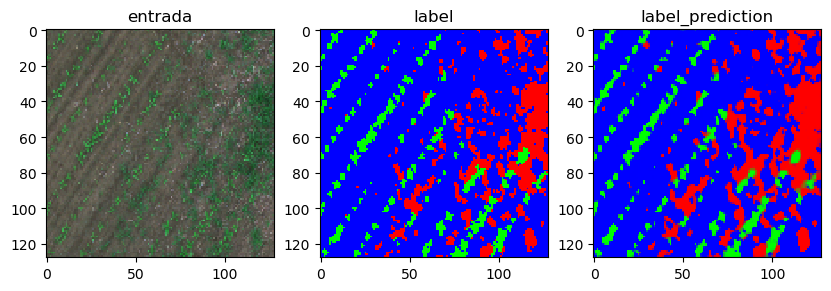

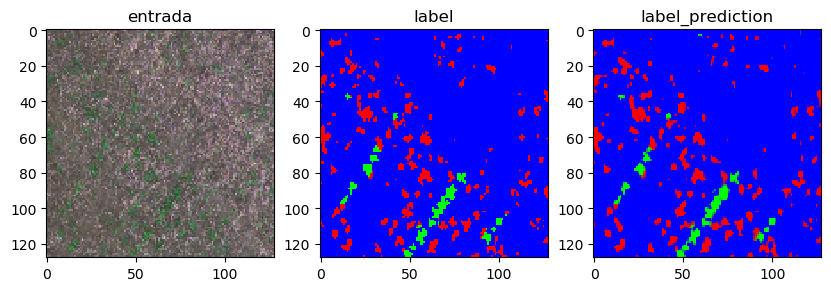

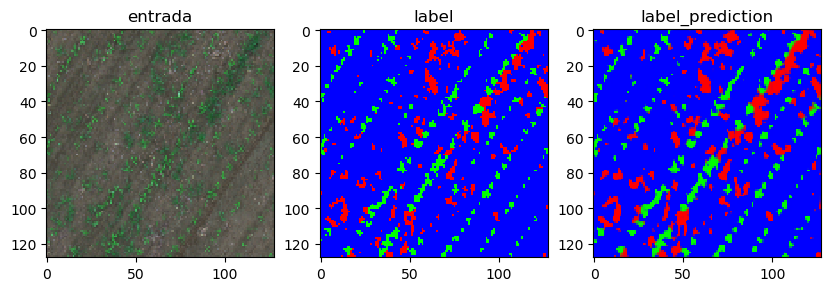

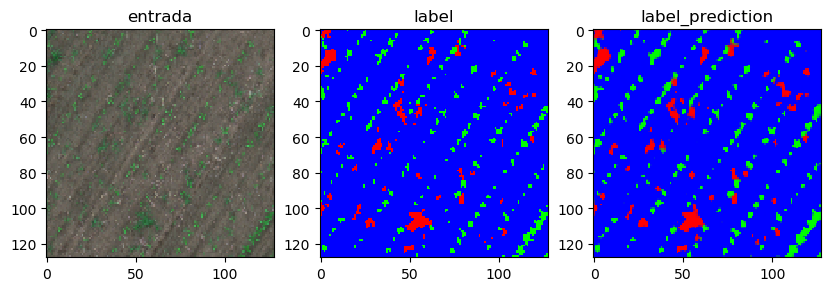

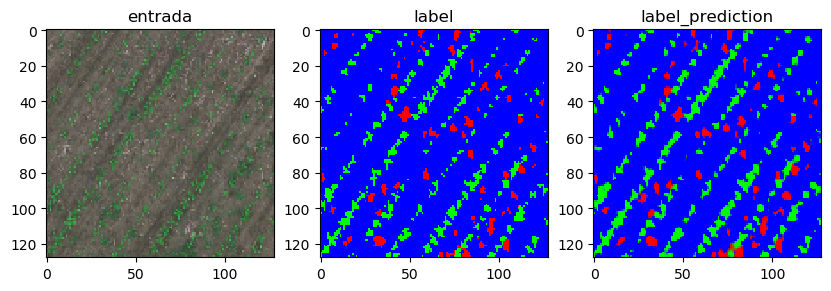

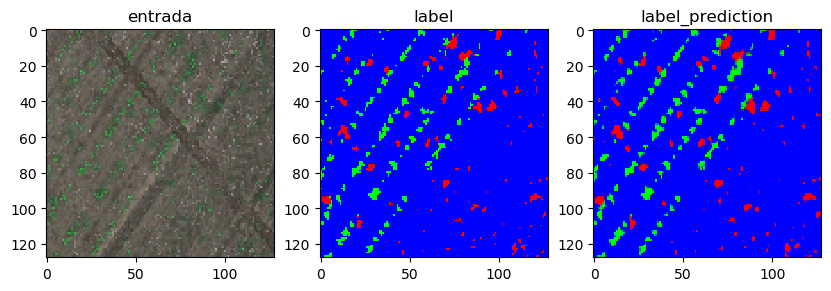

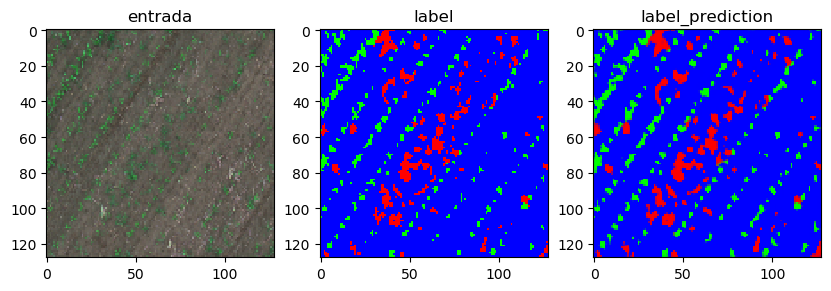

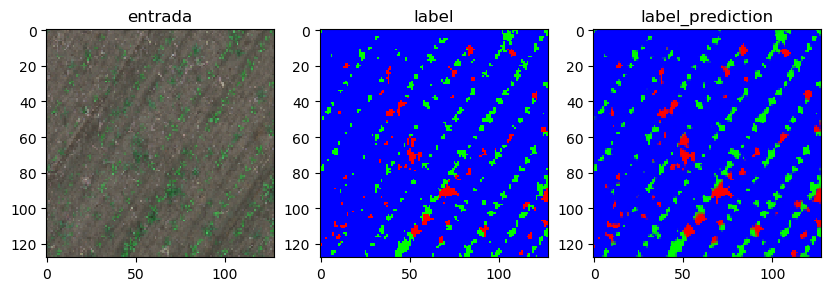

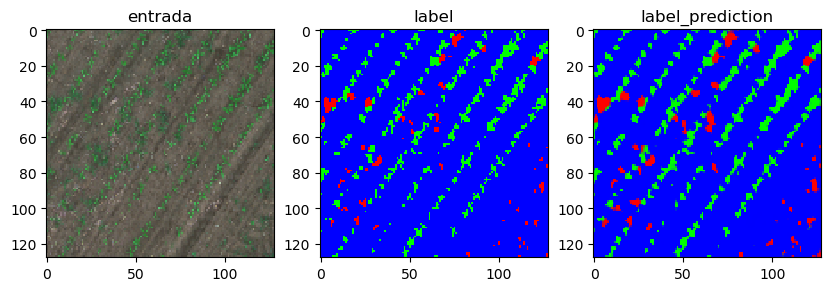

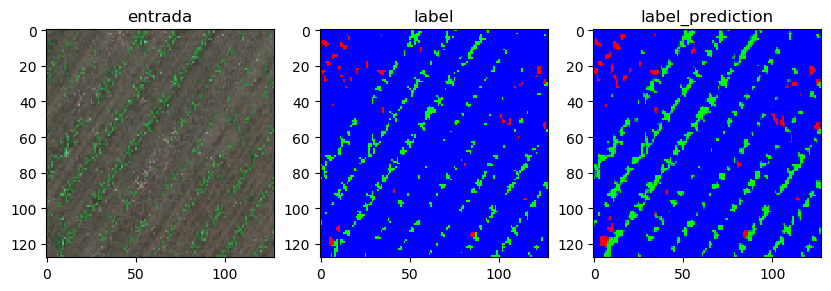

In [32]:
#n=0

for i in range (10):
    n=i
    plt.figure(figsize=(10,8))
    plt.subplot(2,3,1)
    plt.title("entrada")
    plt.imshow(test_x[n])

    plt.subplot(2,3,2)
    plt.title("label")
    img = np.reshape(test_y[n, :],(128,128,3))
    plt.imshow(img)

    prediction = loaded_model.predict(test_x[n:n+1])
    prediction = np.reshape(prediction,(128,128,3))
#prediction = np.argmax(prediction, axis=2)
    plt.subplot(2,3,3)
    plt.title("label_prediction")
    plt.imshow(prediction)
    
    plt.savefig('model_best_n:'+str(n)+'.png')

global metrics

In [136]:
#loss,acc,f1,precision,recall,mean_iou = loaded_model.evaluate(test_x,test_y, verbose=1)

In [137]:
#print('loss_ts:',loss,'f1:',f1,'mean_iou:',mean_iou,'acc:',acc) #global metrics

Clases metrics

In [33]:
for a in range(10):

#y_pred=model.predict(test_x[1])
    y_true= test_y[a:a+1].reshape(128,128,3)
    y_true
#y_true.shape
    y_true=np.argmax(y_true, axis=2)
#y_true=y_true.reshape(16384, 3)
    y_true = np.reshape(y_true,(128*128))

#f1_m=f1(y_true, y_pred)
    y_pred = loaded_model.predict(test_x[a:a+1])
    y_pred=y_pred.reshape(16384, 3)
    y_pred = np.reshape(y_pred,(128,128,3))
    y_pred = np.argmax(y_pred, axis=2)
    y_pred = np.reshape(y_pred,(128*128))
    from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
    F1_list=f1_score(y_pred, y_true,average=None)
    precision=precision_score(y_pred, y_true,average=None)
    recall_score=recall_score(y_pred, y_true,average=None)
    print('F1:',F1_list,'precision:',precision)#,'recall_score:',recall_score)
    ##F1_list=[]
#for i in range(100):
    
#F1_list=f1_score(y_pred, y_true,average=None)
#precision=precision_score(y_pred, y_true,average=None)
#recall_score=recall_score(y_pred, y_true,average=None)
#print('F1:',F1_list,'precision:',precision,'recall_score:',recall_score)

F1: [0.84801477 0.88625124 0.95847039] precision: [0.97994025 0.9149081  0.92706013]
F1: [0.82056893 0.87556222 0.98123233] precision: [0.85812357 0.89846154 0.9766748 ]
F1: [0.78866667 0.83914894 0.96659129] precision: [0.96335505 0.94354067 0.93905464]
F1: [0.83845548 0.81193124 0.98153857] precision: [0.92361111 0.96514423 0.96741453]
F1: [0.82578665 0.85217903 0.97495458] precision: [0.90420168 0.97902571 0.95611767]
F1: [0.81767956 0.85807292 0.98673124] precision: [0.90983607 0.96769457 0.97752218]
F1: [0.85190409 0.82475158 0.97590319] precision: [0.91422805 0.97751606 0.95933329]
F1: [0.78994614 0.85274378 0.98059819] precision: [0.95032397 0.95914742 0.96505576]
F1: [0.76822633 0.86808256 0.97789939] precision: [0.97513812 0.9777628  0.95872885]
F1: [0.70559611 0.73119154 0.97397819] precision: [0.97315436 0.99557032 0.9496478 ]
